### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##### Loading & observing the data

In [3]:
## load json file as pandas dataframe
login_df = pd.read_json('logins.json')
login_df.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


In [4]:
## observing the data
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


##### Aggregating login counts to 15-minutes intervals

In [6]:
login_df['count'] = 1
login_df.set_index('login_time', inplace=True)
login_df_15min = login_df.resample('15T', how='sum')
login_df_15min.head(3)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9


In [7]:
## add day of the week
login_df_15min.reset_index(inplace=True)
week_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
login_df_15min['weekday'] = login_df_15min.login_time.apply(lambda x: week_map[x.weekday()])
login_df_15min.set_index('login_time', inplace=True)
login_df_15min.head(3)

,count,weekday
login_time,,
1970-01-01 20:00:00,2,Thursday
1970-01-01 20:15:00,6,Thursday
1970-01-01 20:30:00,9,Thursday


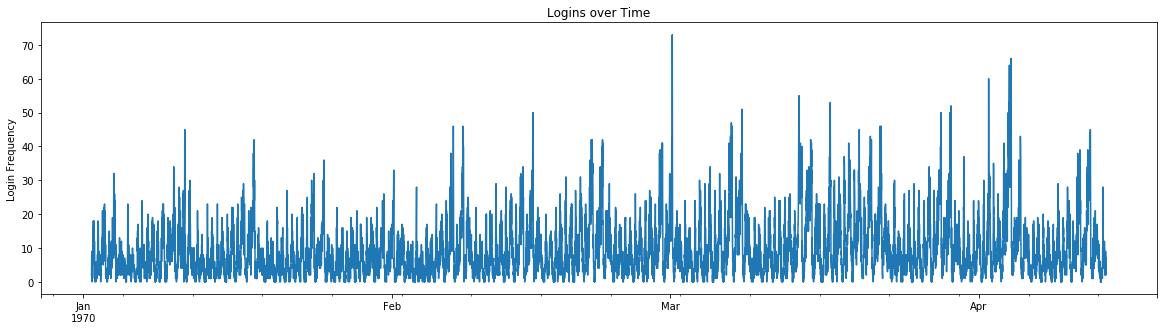

In [8]:
## plot login frequency over time
login_df_15min.plot(figsize=(20,5), legend=None)
plt.xlabel("")
plt.ylabel('Login Frequency')
plt.title('Logins over Time')
plt.show()

From the above chart, we can easily see the recurrence of peaks and valleys on a weekly basis. In each month, we can observe 4 U-shaped patterns, roughly 1 for each week. To better observe the trend on a weekly and daily basis, I will plot the logins for the first week of March and each day within that week. 

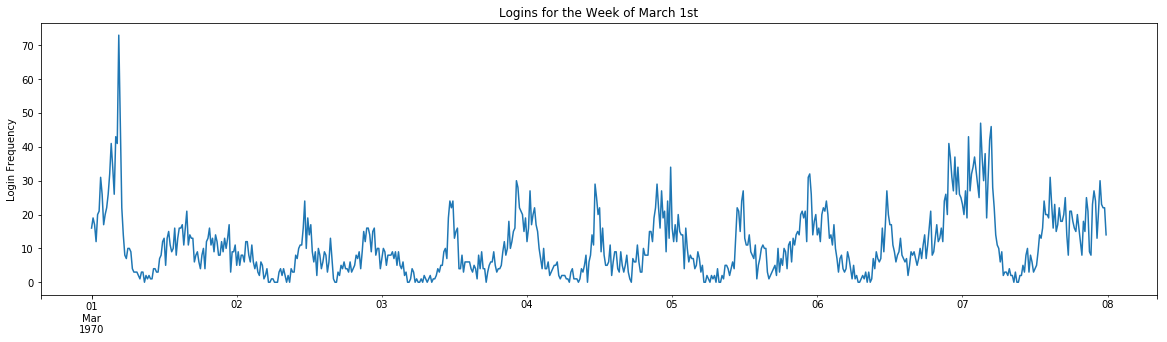

In [9]:
## plot the login frequencies for the first week of March
march_df = login_df_15min['1970-03-01': '1970-03-07']
march_df.plot(figsize=(20,5), legend=None)
plt.xlabel("")
plt.ylabel('Login Frequency')
plt.title('Logins for the Week of March 1st')
plt.show()

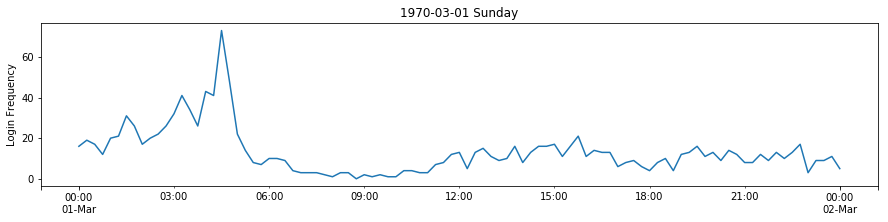

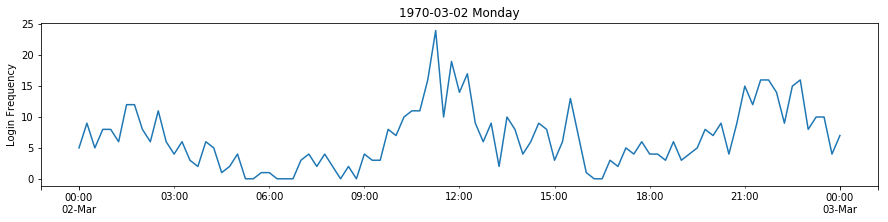

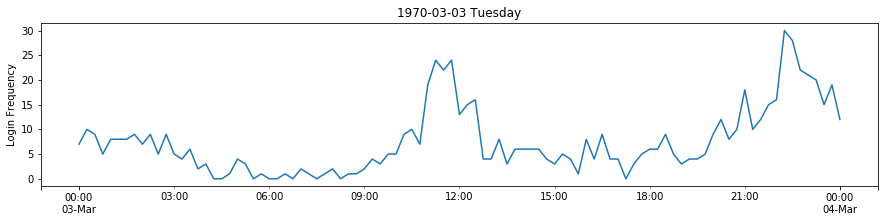

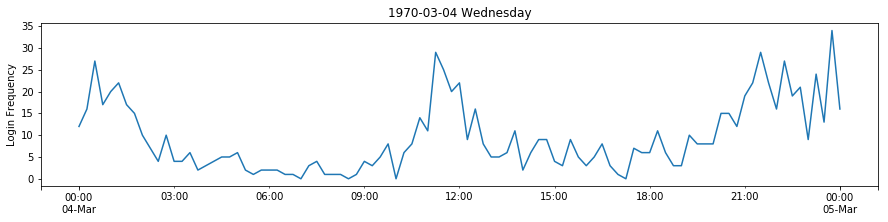

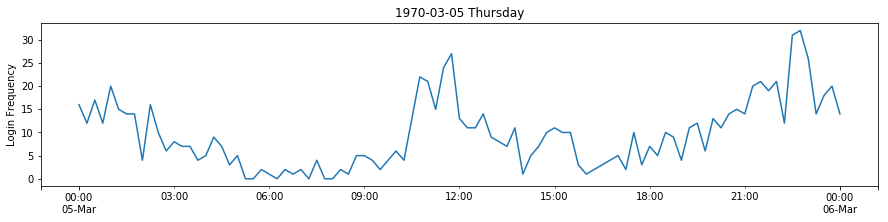

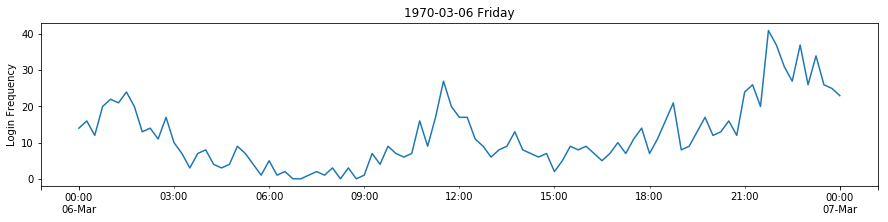

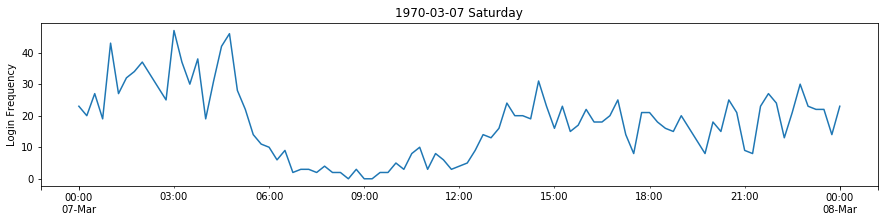

In [10]:
## plot the daily login frequencies for the first week of March
for day in pd.date_range('1970-03-01', '1970-03-07'):
    login_df_15min[day: day+1].plot(figsize=(15,3), legend=None)
    plt.xlabel("")
    plt.ylabel('Login Frequency')
    plt.title(str(day.date()) + ' ' + login_df_15min[day:day].weekday.values[0])

For all weekdays during the week, there appear to be two peaks during lunch time and at night from 9pm to midnight. On weekend, we had more logins from midnight to dawn.

### Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs

##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The metric can be the number of drivers that go across the bridge before and after the experiment. This is a direct measurement of whether the drive parters are serving both cities or exclusively one city. 

To be more specific, we can set the metrics as a 10% increase in the number of drivers that go across the bridge per month to indicate the success in the experiment. 

##### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
##### a. how you will implement the experiment
##### b. what statistical test(s) you will conduct to verify the significance of the observation
##### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

##### The Test
I will obtain the data for both pre- and post-reimbursement and conduct a hypothesis test to measure if the change in the driving behavior caused by the reimbursement of the toll costs is significant or not. 

H0: There is no difference in the mean number of drivers acrossing the bridge per month pre- and post-reimbursement. 

H1: There is significant difference in the mean number of drivers acrossing the bridge. 

Significance level = 0.05

If we assume that the sample size is bigger than 30 and each driver's decision is independant from one another, according to Central Limited Theorem, we can assume that the distribution of the average number of drivers acrossing the bridge per month is normally distributed. 

We then calculate the z-score and the p-value (the probability of getting the difference in the average number of drivers assuming the null hypothesis is true). 

##### Interpretation
If p-value is less than our significance level of 0.05, we can conclude that the post-reimbursement frequencies are very different from the pre-reimbursement frequencies that the difference is unlikely to occur under the null hypothesis. Thus, we can reject the null hypotheis and conclude that the difference of mean number of drivers acrossing the bridge before and after the experiment is statistically significant. If the z-score is positive under this case, it is safe to say that the increase in the  number of drivers caused by the new policy is statistically significant.  

##### Caveats
The significance level is set arbitrarily. If we use a different significance level, we could have a completely opposite conclusion. In addition, the increase in the number of drivers may be statistically significant, but the benefit brought by the increase may not justify the cost we would spend on the reimbursement. Whether to keep the new policy is a business decision in addition to the statistical proof. 

### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [11]:
## load the json file
data = json.load(open('ultimate_data_challenge.json'))
rider_df = pd.DataFrame(data)
rider_df.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0


In [12]:
## observe the data
rider_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
rider_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


#### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

##### Data Cleaning

In [14]:
## change last_trip_date & signup_date to datetime format
rider_df.last_trip_date = pd.to_datetime(rider_df.last_trip_date)
rider_df.signup_date = pd.to_datetime(rider_df.signup_date)

In [15]:
## check for missing values
## We have missing values in avg_rating_by_driver, avg_rating_of_driver, and phone columns

## fill in the avg_rating columns using mean rating
rider_df['avg_rating_by_driver'].fillna(rider_df['avg_rating_by_driver'].mean(), inplace=True)
rider_df['avg_rating_of_driver'].fillna(rider_df['avg_rating_of_driver'].mean(), inplace=True)

In [16]:
## value counts of the phone column
rider_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [17]:
## since most of the phones are iPhones, we will fill in the missing values in the phone column with iPhone
rider_df['phone'].fillna('iPhone', inplace=True)

##### Exploratory Data Analysis

In [18]:
## set up seaborn color palette
flatui = ["#20639B", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)

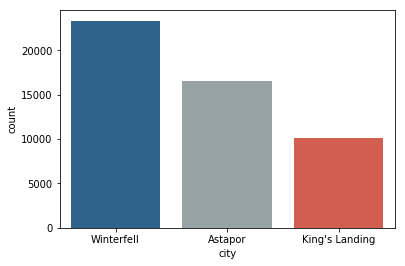

In [19]:
## plot the number of users in each city
sns.countplot(x='city', data=rider_df, order=rider_df.city.value_counts().index)

Winterfell has the most users and King's Landing has the least. 

In [20]:
## add a boolean column to indicate retention. 
## We consider a user retained if they took a trip in the preceding 30 days.
## To get the date that the data was pulled, we will use the last date that a trip was booked as an estimation

from datetime import timedelta
data_collection_date = rider_df.last_trip_date.max()
cutoff_date = data_collection_date - timedelta(days=30)

rider_df['retained'] = [1 if row['last_trip_date']>=cutoff_date else 0 for i, row in rider_df.iterrows()]
rider_df.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0


In [21]:
## percentage of retained users
pct_retained = rider_df.retained.sum()/rider_df.retained.count()
print(round((pct_retained*100), 2), '% of the observed users were retained as of', data_collection_date.date(), '.')

37.61 % of the observed users were retained as of 2014-07-01 .


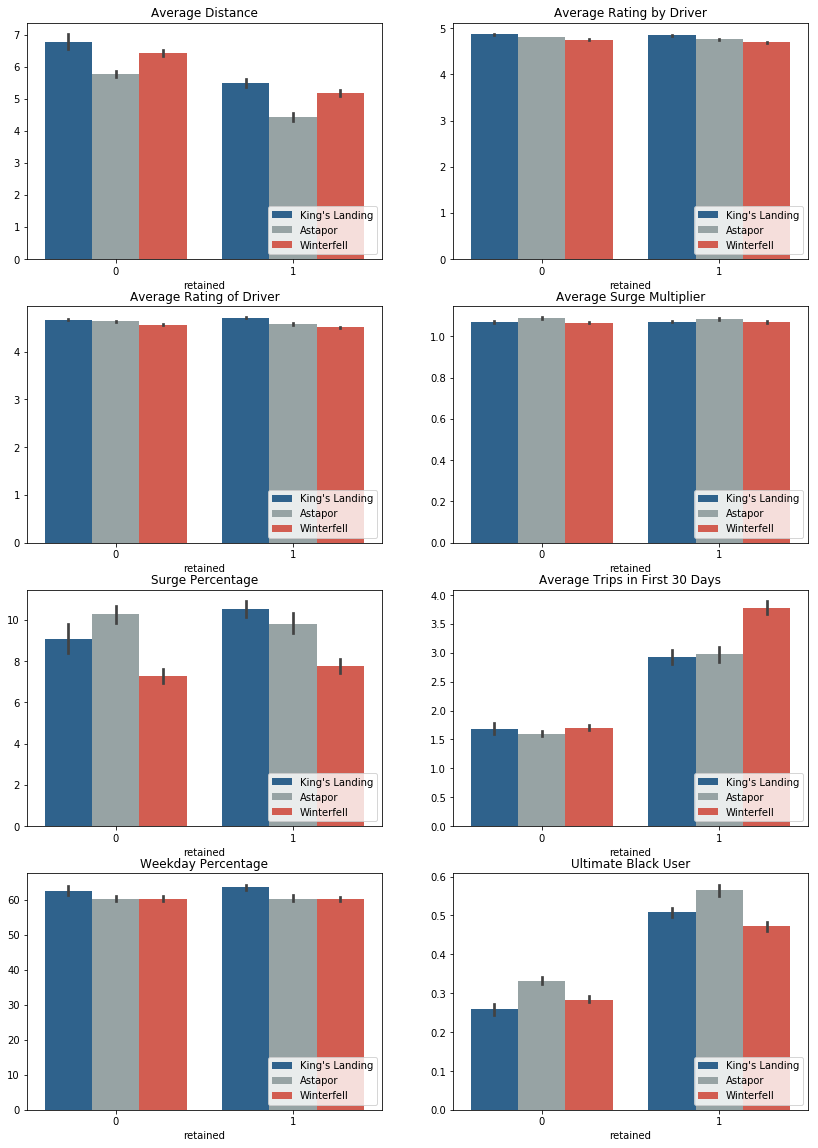

In [22]:
## compare the variables between users that are retained and those that are not
var_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge'
            , 'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'ultimate_black_user']
title_list = ['Average Distance', 'Average Rating by Driver', 'Average Rating of Driver', 'Average Surge Multiplier'
             , 'Surge Percentage','Average Trips in First 30 Days', 'Weekday Percentage', 'Ultimate Black User']
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(14,20))

for i, var in enumerate(var_list):
    if i%2 == 0:
        ax = axes[(i//2)][0]
    else:
        ax = axes[(i//2)][1]
    sns.barplot(x='retained', y=var, data=rider_df, hue='city', ax=ax)
    ax.set_ylabel('')
    ax.set_title(title_list[i])
    ax.legend(loc='lower right')

Observations:
* Retained users have a slightly lower average travel distance, but remarkably higher number of trips taken in first 30 days after registration
* Riders who have used Ultimate Black are more likely to stay active. 

In [23]:
## correlation between variables
corr = rider_df.corr()
corr.style.background_gradient(cmap='PuBu', low=0, high=0.3).set_precision(4)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
avg_dist,1,0.07979,0.02851,-0.08149,-0.1044,-0.1363,0.03231,0.1017,-0.09278
avg_rating_by_driver,0.07979,1,0.1017,0.0105,0.01996,-0.0391,0.009328,0.02037,-0.02675
avg_rating_of_driver,0.02851,0.1017,1,-0.02165,-0.00329,-0.01106,-0.001916,0.01259,-0.01083
avg_surge,-0.08149,0.0105,-0.02165,1,0.7936,-0.001841,-0.07879,-0.1101,-0.003333
surge_pct,-0.1044,0.01996,-0.00329,0.7936,1,0.00572,-0.1069,-0.1449,0.0118
trips_in_first_30_days,-0.1363,-0.0391,-0.01106,-0.001841,0.00572,1,0.1122,0.05039,0.2105
ultimate_black_user,0.03231,0.009328,-0.001916,-0.07879,-0.1069,0.1122,1,0.036,0.205
weekday_pct,0.1017,0.02037,0.01259,-0.1101,-0.1449,0.05039,0.036,1,0.009693
retained,-0.09278,-0.02675,-0.01083,-0.003333,0.0118,0.2105,0.205,0.009693,1


Average surge and surge percentage are highly correlated. Among all the variables, user has the highest positive correlation with trips_in_first_30_days and ultimate_black_user. 

Next, we will build a model to use the features to predict user retention and find the most predictive features. 

#### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance

Since the users in the dataset signed up in January and the data was collected in July, most of the users are in their 6th month. Therefore, the retained column is a good indication of whether or not a user will be active in their 6th month on the system. 

In [24]:
## get dummy variables for categorical features
df = pd.get_dummies(rider_df, columns=['city', 'phone', 'ultimate_black_user'])

## drop date columns
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,0,1,1,0,1,0


In [39]:
## setting up features & labels
X = df.drop('retained', axis=1)
y = df.retained

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [40]:
## baseline model - Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
print('Accuracy on training set: ', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_pred))

Accuracy on training set:  0.71616
Accuracy on test set:  0.71872


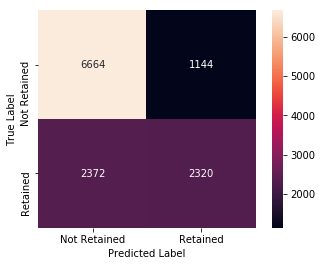

In [42]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, xticklabels=['Not Retained', 'Retained'], 
           yticklabels=['Not Retained', 'Retained'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The baseline model gave us a 71.87% accuracy. There are other models for classification and we will evaluate 2 other models including RandmForest and XGBoost to find the best performing one. 

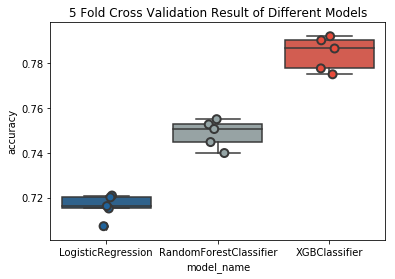

In [45]:
## model selection

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    xgb.XGBClassifier()
]

cv=5
cv_df = pd.DataFrame(index=range(cv * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('5 Fold Cross Validation Result of Different Models')
plt.show()

XGBoost has the best performance among the three model tested. Let's use XGBoost to build a new model. 

In [50]:
## fit XGBoost
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred = xgb_clf.predict(X_test)
print('Accuracy on training set: ', metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_pred))

Accuracy on training set:  0.78864
Accuracy on test set:  0.78944


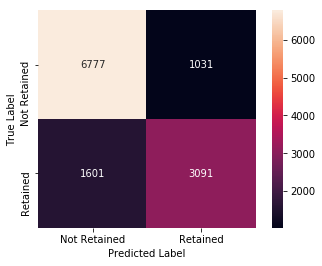

In [47]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, xticklabels=['Not Retained', 'Retained'], 
           yticklabels=['Not Retained', 'Retained'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Not Retained', 'Retained']))

              precision    recall  f1-score   support

Not Retained       0.81      0.87      0.84      7808
    Retained       0.75      0.66      0.70      4692

 avg / total       0.79      0.79      0.79     12500



Under this model, we have relatively high accuracy and recall for churned users, meaning that we have a good prediction for users who are going to leave. With the prediction, we could accurately target those users to motivate them to stay with the company. 

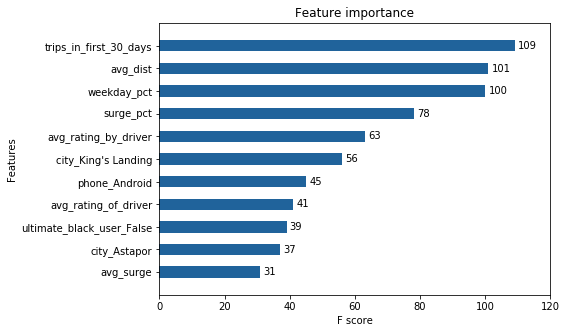

In [51]:
## plot feature importance of XGBoost
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(7,5))
plot_importance(xgb_clf, grid=False, height=0.5, ax=ax)
plt.show()

#### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice)

From the above feature importance plot, we notice that trips_within_30_days and avg_distance are the top 2 predictive factors of client retention and churn rate. From previous analysis we know that customers with lower number of trips and longer average travel distance within their first 30 days of registration are more likely to churn. These customers may include users that registered for one-time long distance travel or users who registered but didn't actively use the service. 

Recommendation 1: To increase the usage of the service after registration, Ultimate could offer discounts on first few trips to ecourage the new customers to start using the service and get into a habit to keep using it. The company could also implement targeted ad at new users to remind them of the service. 

Weekday_pct is listed as the third important feature for the prediction. The below plot shows that active users use the service more regulary as a mean of transportation while the distribution of churned users is almost bimodal. 

Recommendation 2: To encourage riders to take more rides on weekdays, Ultimate could consider to offer weekday discounts or carpool options during work hour. 

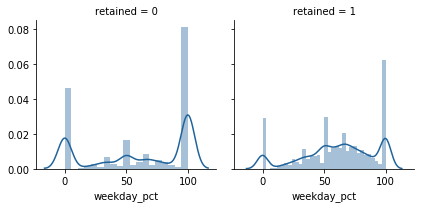

In [53]:
## plot the distribution of weekday_pct between churned and retained user
g = sns.FacetGrid(rider_df, col='retained')
g.map(sns.distplot, 'weekday_pct')
plt.show()

Even though black_ultimate_user does not rank high in the feature importance, we recall that this feature is positively correlated with the retention rate. This could result from positive user experience with the Ultimate Black service. 

Recommendation 3: To keep those users, the company could also implement cash backs for Ultimate Black to encourage more frequent usage. Meanwhile, the cash back policy would also help to attrack more customers to start using Ultimate Black and eventually stay as active users.   